In [1]:
# default_exp audio.dataset

# Audio Datasets

> This module defines datasets to use with audio data from Deep Learning applications

In [2]:
#hide
from nbdev.export import notebook2script

In [3]:
#export 
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from librosa.display import __coord_mel_hz as coord_mel_hz
from warnings import warn
from fastcore.all import *
from dl_pipeline.audio.core import *
from dl_pipeline.audio.augmentations import *
from IPython.core.debugger import set_trace
from fastai.torch_core import TensorBase
from fastai.data.core import Datasets, DataLoader, DataLoaders
from fastai.vision.all import TensorImage

The data structure for the audio labels is defined by a dataframe with the columns `(id, label, tmin, tmax, fmin, fmax)` (see example bellow). Each row defines a bounding box of time and frequency for some label in the corresponding audio clip. Multiple boxes may exist for the same audio id.

|id|label|tmin|tmax|fmin|fmax|...|
|--|-----|----|----|----|----|---|
|a239gfdda|10|2.4|4.1|5000|10000|...|
|b94k2g0as|4|23.7|40.3|2500|7000|...|

In [4]:
#export
class Datasets(Datasets): pass
class DataLoader(DataLoader): pass
class DataLoaders(DataLoaders): pass

class RenameColumns(Transform):
    def __init__(self, id='id', label='label', tmin='tmin', tmax='tmax', fmin='fmin', fmax='fmax'):
        self.id, self.label, self.tmin, self.tmax = id, label, tmin, tmax
        self.fmin, self.fmax = fmin, fmax
    
    def encodes(self, df:pd.DataFrame):
        return df.rename(columns={self.id: 'id', self.label: 'label', self.tmin: 'tmin', 
                                  self.tmax: 'tmax', self.fmin: 'fmin', self.fmax: 'fmax'})
    
def load_dataframe(file): 
    return pd.read_csv(file)

def group_labels(df):
    return df.groupby('id').agg(lambda x : list(x)).reset_index()

In [5]:
%%time
path = Path('/kaggle/kaggle_rainforest_audio/data')
rename_cols = RenameColumns(id='recording_id', label='species_id', tmin='t_min', 
                            tmax='t_max',fmin='f_min', fmax='f_max')
df = Pipeline([load_dataframe, rename_cols, group_labels])(path/'train_tp.csv')
df.head()

CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 131 ms


,id,label,songtype_id,tmin,fmin,tmax,fmax
0,003bec244,[14],[1],[44.544],[2531.25],[45.1307],[5531.25]
1,006ab765f,[23],[1],[39.9615],[7235.16],[46.0452],[11283.4]
2,007f87ba2,[12],[1],[39.135999999999996],[562.5],[42.272],[3281.25]
3,0099c367b,[17],[4],[51.4206],[1464.26],[55.1996],[4565.04]
4,009b760e6,[10],[1],[50.0854],[947.461],[52.5293],[10852.7]


In [6]:
#export
def time2pix_image(t, clip_duration, image_width):
    return int(t*image_width/clip_duration)

def time2pix_wave(t, clip_duration, n_samples):
    return int(t*n_samples/clip_duration)

def pix2time(pix, clip_duration, image_width):
    return clip_duration*pix/image_width

def pix2pix_image(pix, image_width, n_samples):
    return int(pix*image_width/n_samples)

def time_labels(lbl, tmin, tmax, fmin, fmax, sample_rate, clip_duration, image_width, n_mels,
                num_classes=None):
    #TODO: MultiCategory case with overlaping bounding boxes
    if num_classes is None:
        label = np.zeros((n_mels,image_width))*np.nan
    else:
        label = np.zeros((n_mels,image_width,num_classes))
    freqs = coord_mel_hz(n_mels, fmax=sample_rate//2)
    for t0, tm, f0, fm, l in zip(tmin, tmax, fmin, fmax, lbl):
        t0pix = time2pix_image(t0, clip_duration, image_width)
        tmpix = time2pix_image(tm, clip_duration, image_width)
        f0pix = np.abs(freqs-f0).argmin()
        fmpix = np.abs(freqs-fm).argmin()
        if num_classes is None:
            label[f0pix:fmpix, t0pix:tmpix] = l
        else: 
            label[f0pix:fmpix, t0pix:tmpix,l] = 1
            label = label.astype(np.uint8)
    return label

def audio_crop(wav, df_row, sample_rate, hop_length=512, n_mels=128, tile_width=256,
               num_classes=None):
    e = np.random.permutation(list(range(len(df_row['label']))))[0]
    n_samples = len(wav)
    image_width = int(n_samples/hop_length+1)
    clip_duration = n_samples/sample_rate
    window_size = int(tile_width/image_width*n_samples)
    slice_start = int(df_row['tmin'][e]*n_samples//clip_duration)
    slice_end = int(df_row['tmax'][e]*n_samples//clip_duration)
    time_label = time_labels(df_row['label'], df_row['tmin'], df_row['tmax'], df_row['fmin'],
                             df_row['fmax'], sample_rate, clip_duration, image_width, n_mels,
                             num_classes=num_classes)
    p2p = partial(pix2pix_image, image_width=image_width, n_samples=n_samples)
    w = slice_end-slice_start
    if w <= window_size:
        slice_start -= (window_size-w)//2
        if slice_start+window_size>n_samples:
            wav = wav[-window_size:]
            time_label = time_label[:,-p2p(window_size):]
        else:
            wav = wav[max(0,slice_start):max(0,slice_start)+window_size]
            time_label = time_label[:, p2p(max(0,slice_start)):p2p(max(0,slice_start)+window_size)]
    else:
        rnd = np.random.randint(0, int(w-window_size), 1)[0]
        wav = wav[slice_start+rnd:slice_start+rnd+window_size]
        time_label = time_label[:, p2p(slice_start+rnd):p2p(slice_start+rnd+window_size)]
    if time_label.shape[-1] < tile_width: # Fix: Sometimes time_label width is 255 instead of 256 
        if num_classes is None:
            time_label2 = np.zeros((n_mels, tile_width))*np.nan
        else:
            time_label2 = np.zeros((n_mels, tile_width, num_classes))*np.nan
        time_label2[:,:time_label.shape[1]] = time_label
        time_label = time_label2
    if num_classes is not None:
        time_label = time_label.transpose(2,0,1).astype(np.uint8)
    return wav, time_label

class TilesTransform(Transform):
    def __init__(self, tile_width, sliding_window=True):
        self.tile_width = tile_width
        self.sliding_window = sliding_window
        
    def encodes(self, xb:TensorImage):
        xb1 = xb[...,:self.tile_width*(xb.shape[-1]//self.tile_width)].view(
             *xb.shape[:-1], -1, self.tile_width).permute(0,3,1,2,4)
        xb1 = xb1.reshape(xb1.shape[0]*xb1.shape[1], *xb1.shape[2:])
        if self.sliding_window:
            xb2 = xb[...,self.tile_width//2:]
            xb2 = xb2[...,:self.tile_width*(xb2.shape[-1]//self.tile_width)].view(
                 *xb2.shape[:-1], -1, self.tile_width).permute(0,3,1,2,4)
            xb2 = xb2.reshape(xb2.shape[0]*xb2.shape[1], *xb2.shape[2:])
            xb = torch.cat((xb1, xb2), dim=0)
        else: xb = xb1
        return xb

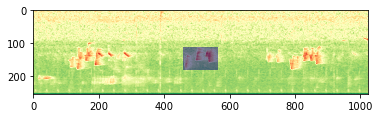

CPU times: user 759 ms, sys: 86.4 ms, total: 845 ms
Wall time: 511 ms


In [7]:
%%time
sample_rate, hop_length, n_mels, tile_width = 32000, 320, 256, 1024
i = 15
wav = load_npy(path/'npy32000'/'train'/f'{df.loc[i].id}.npy')
wav, label = audio_crop(wav, df.loc[i], sample_rate=sample_rate,  hop_length=320,
                        n_mels=n_mels, tile_width=tile_width, num_classes=24)
if len(label.shape) == 3: 
    label = label.max(0)
    label = label.astype(np.float32)
    label[label==0] = np.nan
plt.imshow(melspectrogram(wav, sample_rate, n_mels=n_mels, hop_length=hop_length)[0], cmap='RdYlGn_r')
plt.imshow(label, alpha=0.5, cmap='jet')
plt.show()

In [8]:
#export
def reorganize_batch(o):
    xb, yb = [], []
    for i in range(len(o)):
        xb.append(o[i][0][0][None])
        yb.append(o[i][0][1][None])
    xb = torch.cat(xb,dim=0)
    yb = torch.cat(yb,dim=0)
    return TensorAudio(xb), TensorAudioLabel(yb)

def create_dataset_item(df_row, sample_rate, path=Path('.'), tile_width=256, hop_length=512, 
                        n_mels=128, num_classes=None):
    fn = path/f'npy{sample_rate}'/'train'/f'{df_row.id}.npy'
    wav = load_npy(fn)
    if tile_width is not None:
        wav, label = audio_crop(wav, df_row, sample_rate=sample_rate, tile_width=tile_width,
                                n_mels=n_mels, hop_length=hop_length, num_classes=num_classes)
    else: 
        try: label = torch.FloatTensor([df_row.label[0]])
        except:
            warn('label column not found in dataframe, setting label to zero.')
            label = torch.FloatTensor([0])
    return TensorAudio(wav), TensorAudioLabel(label)

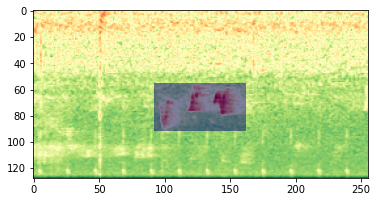

CPU times: user 1.85 s, sys: 734 ms, total: 2.58 s
Wall time: 2.27 s


In [9]:
%%time
path = Path('/kaggle/kaggle_rainforest_audio/data')
rename_cols = RenameColumns(id='recording_id', label='species_id', tmin='t_min', 
                            tmax='t_max',fmin='f_min', fmax='f_max')
df = Pipeline([load_dataframe, rename_cols, group_labels])(path/'train_tp.csv')
data = Datasets(items=df, tfms=partial(create_dataset_item, path=path, sample_rate=32000, 
                                       tile_width=256, num_classes=24))
dls = DataLoader(data, bs=64, do_batch=reorganize_batch)
xb, yb = dls.one_batch()

wav, label = data[15][0][0], data[15][0][1].max(0).values.float()
label[label==0] = np.nan
plt.imshow(melspectrogram(wav, sample_rate)[0], cmap='RdYlGn_r')
plt.imshow(label, alpha=0.5, cmap='jet')
plt.show()

In [10]:
#export
def apply_augmentations(o, augs_pipeline=lambda o:o):
    x, y = o[0][0], o[0][1]
    x = augs_pipeline(x)
    return [(x, y)]

def audio_augment(sample_rate, p=0.5, gaussianSNR=True, gain=True, clipping=True,
                  pitchshift=True, timestretch=True, freq_mask=True, time_mask=True, 
                  shift=True, extra_augs=[], **kwargs):
    augs = []
    if gaussianSNR: augs.append(AddGaussianSNR(sample_rate, p=p, **kwargs))
    if gain: augs.append(Gain(sample_rate, p=p, **kwargs))
    if clipping: augs.append(ClippingDistortion(sample_rate, p=p, **kwargs))
    if pitchshift: augs.append(PitchShift(sample_rate, p=p, **kwargs))
    if timestretch: augs.append(TimeStretch(sample_rate, p=p, **kwargs))
    if shift: augs.append(Shift(sample_rate, p=p, **kwargs))
    if freq_mask: augs.append(FrequencyMask(sample_rate, p=p, **kwargs))
    if time_mask: augs.append(TimeMask(sample_rate, p=p, **kwargs))
    return Pipeline([*augs, *extra_augs])

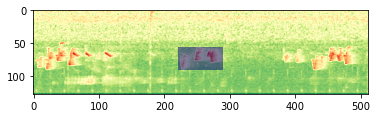

CPU times: user 4.67 s, sys: 396 ms, total: 5.06 s
Wall time: 4.3 s


In [11]:
%%time
path = Path('/kaggle/kaggle_rainforest_audio/data')
rename_cols = RenameColumns(id='recording_id', label='species_id', tmin='t_min', 
                            tmax='t_max',fmin='f_min', fmax='f_max')
df = Pipeline([load_dataframe, rename_cols, group_labels])(path/'train_tp.csv')
data = Datasets(items=df, tfms=partial(create_dataset_item, path=path, sample_rate=32000, 
                                       tile_width=512, n_mels=128, hop_length=512))
augs = audio_augment(sample_rate, p=0.25)
augs.max_frequency_band=0
augs.max_band_part =0
dls = DataLoader(data, 
                 bs          = 20, 
                 do_batch    = reorganize_batch,             
                 after_item  = partial(apply_augmentations, augs_pipeline=augs),
                 after_batch = MelSpectrogram(sample_rate, n_mels=128, hop_length=512))
xb, yb = dls.one_batch()
img, label = xb[15], yb[15]
plt.imshow(img[0], cmap='RdYlGn_r')
plt.imshow(label, alpha=0.5, cmap='jet')
plt.show()

In [12]:
#export
def show_augmentations(data, dls, sample_rate, n=10, cmap='RdYlGn_r', vmin=-2, vmax=4):
    s = dls.shuffle
    dls.shuffle = False
    xb1, yb1 = dls.one_batch()
    xb2, yb2 = dls.one_batch()
    xb3, yb3 = dls.one_batch()
    dls.shuffle = s
    fig, axes = plt.subplots(ncols=4, nrows=n, figsize=(10,20), dpi=150)
    for i, x1, x2, x3, y1, y2, y3 in zip(range(n), xb1, xb2, xb3, yb1, yb2, yb3):
        mel = melspectrogram(data[i][0][0].cpu(), sample_rate)[0]
        mel = (mel-mel.mean())/mel.std()
        axes[i][0].imshow(mel.cpu(), cmap='RdYlGn_r', vmin=vmin, vmax=vmax)
        axes[i][0].imshow(data[i][0][1].cpu(), alpha=0.5, cmap='jet')
        for j, x, y in zip(range(1,4), [x1,x2,x3], [y1,y2,y3]):
            axes[i][j].imshow(x[0].cpu(), cmap='RdYlGn_r', vmin=vmin, vmax=vmax)
            axes[i][j].imshow(y.cpu(), alpha=0.5, cmap='jet')
    fig.tight_layout()

CPU times: user 13.4 s, sys: 427 ms, total: 13.8 s
Wall time: 9.08 s


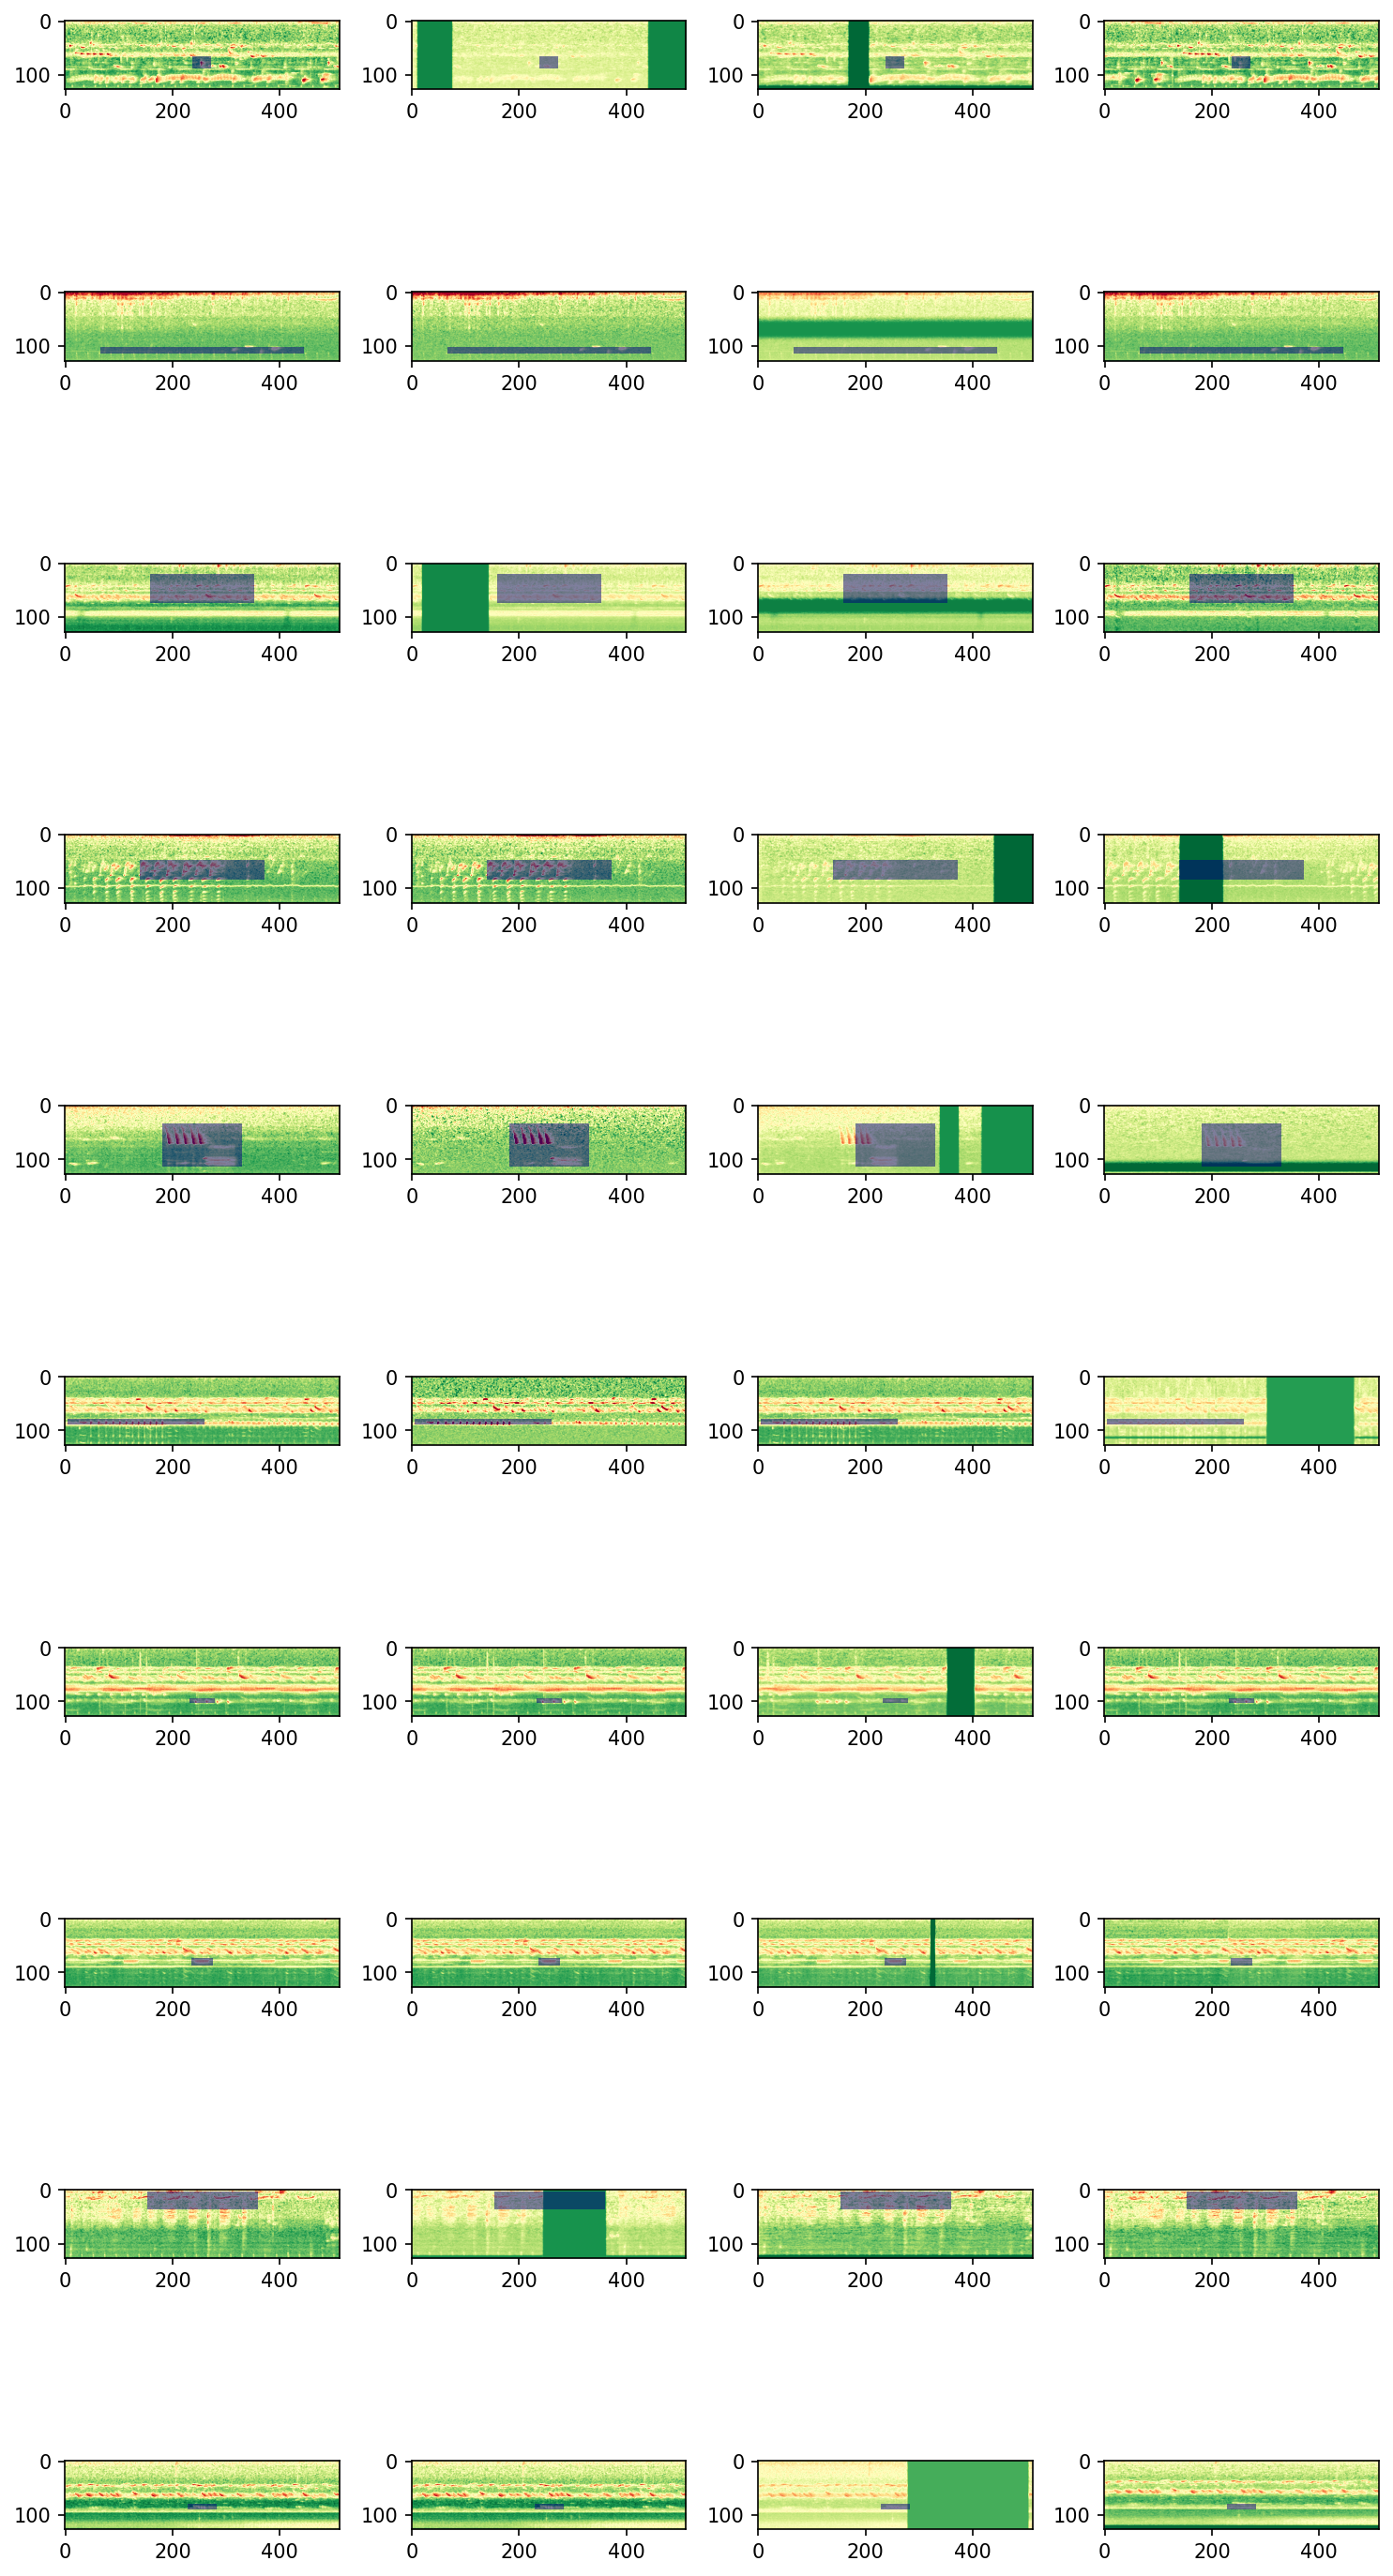

In [13]:
%%time
show_augmentations(data, dls, sample_rate=32000)

In [14]:
#hide
notebook2script()

Converted 00_core.ipynb.
Converted 00vision_losses.ipynb.
Converted 00vision_models.ipynb.
Converted 00vision_triplet.ipynb.
Converted 01audio_augmentations.ipynb.
Converted 01audio_core.ipynb.
Converted 01audio_dataset.ipynb.
Converted 01audio_util.ipynb.
Converted 88_external_xresnet_ssa.ipynb.
Converted index.ipynb.
Converted kaggle_rfcx-species-audio-detection-sed.ipynb.
Converted kaggle_rfcx-species-audio-detection.ipynb.
